In [106]:
from __future__ import print_function
import tarfile

from os import listdir,remove
from os.path import exists, join, basename

from six.moves import urllib
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torch.utils.data as data

from math import log10
import sys
import time
import numpy as np
#import argparse
import easydict      #rd
import cv2
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

from model import Net

from matplotlib import pyplot as plt

#  Prepare Data                                 <br>
Download data if can't find it in local directory           <br>
Get training set from  './dataset/HR_img_train', get testset from  './dataset/HR_img_test'     <br>


In [75]:
def download_bsd300(dest=".//dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as file:
            print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir    #rd


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)    #rd    what does this mean?

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])  #rd


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input_image = load_img(self.image_filenames[index])
        target = input_image.copy()
        # print(target.size)
        if self.input_transform:
            input_image = self.input_transform(input_image)
        else:
            transi = Compose([
                            Resize((input_image.size[1] // 4, input_image.size[0] // 4), Image.BICUBIC),
                            ToTensor()
                            ])
            input_image = transi(input_image)
        if self.target_transform:
            target = self.target_transform(target)
        else:
            transt = Compose([
                ToTensor()
            ])
            target = transt(target)

        # print(input_image.size(), target.size())
        return input_image, target

    def __len__(self):
        return len(self.image_filenames)

def input_transform(crop_size, upscale_factor):   #get the low resolution input by original image.  This is a function, return can be viewed
                                                  # as a set of parameters import into DatasetFromFolder.input_trainsform and target_transform
    return Compose([
        CenterCrop(crop_size),                        #get a small size of data, Corp with less pieces and resize corp? what does corp mean 
                                                      # in this project? why not whole img
        Resize(crop_size // upscale_factor),           # Resize is what? any help? a way to down size? is it reliable?
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    # root_dir = download_bsd300()
    root_dir = './/dataset//'
    train_dir = join(root_dir, "HR_img_train//")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=None,
                             target_transform=None
                             # input_transform=input_transform(crop_size, upscale_factor),
                             # target_transform=target_transform(crop_size))
                             )


def get_test_set(upscale_factor):
    # root_dir = download_bsd300()
    root_dir = './/dataset//'
    test_dir = join(root_dir, "HR_img_test//")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=None,
                             target_transform=None
                             # input_transform=input_transform(crop_size, upscale_factor),
                             # target_transform=target_transform(crop_size))
                             )

# Visualize Training precedure

In [76]:
TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output                      #rd

#  Built CNN Model 

In [113]:
class Net(torch.nn.Module):
    def __init__(self, num_channels, upscale_factor, d=32, s=12, m=2):
        super(Net, self).__init__()

        self.first_part = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=d, kernel_size=5, stride=1, padding=2),
                                        nn.PReLU())

        self.layers = []
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0), nn.PReLU()))
        for _ in range(m):

         #    self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1))      # Normal conv

            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1, groups=s))      # MobileNet conv
            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=1, stride=1, padding=0))

        self.layers.append(nn.PReLU())
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0), nn.PReLU()))

        self.mid_part = torch.nn.Sequential(*self.layers)

        self.last_part = nn.ConvTranspose2d(in_channels=d, out_channels=num_channels, kernel_size=9, stride=upscale_factor, padding=3, output_padding=1)

    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out

    def weight_init(self, mean=0.0, std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.0001)
                if m.bias is not None:
                    m.bias.data.zero_()

class FSRCNNTrainer(object):
    def __init__(self, config, training_loader, testing_loader):
        super(FSRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = config.lr
        self.nEpochs = config.nEpochs
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = config.seed
        self.upscale_factor = config.upscale_factor
        self.training_loader = training_loader
        self.testing_loader = testing_loader
        self.testpsnr = 0

    def build_model(self):
        self.model = Net(num_channels=1, upscale_factor=self.upscale_factor).to(self.device)
        self.model.weight_init(mean=0.0, std=0.2)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)  # lr decay

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        for batch_num, (data, target) in enumerate(self.training_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(data), target)
            train_loss += loss.item()
            # print(train_loss / (batch_num + 1))
            loss.backward()
            self.optimizer.step()
            #print('batch_num:', batch_num, '/', len(self.training_loader), 'Loss:', train_loss / (batch_num + 1))
            progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))

    def test(self):
        self.model.eval()
        avg_psnr = 0
        
        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                # psnr
                mse = self.criterion(prediction, target)
                psnr = 10 * log10(1 / mse.item())
                avg_psnr += psnr
                if batch_num%200==0:
                    #progress_bar(batch_num/100, len(self.testing_loader)/100, 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))
                    print('finish %f percent of all test data, PSNR: %.4f'%(batch_num*100/len(self.testing_loader),(avg_psnr / (batch_num + 1))))
            save_path = './/saved_models//'
            if avg_psnr / len(self.testing_loader) > self.testpsnr:
                self.testpsnr = avg_psnr / len(self.testing_loader)
                folder = os.path.exists(save_path)
                if not folder:
                    os.makedirs(save_path)
                    print('create folder to save models')
                torch.save(self.model, save_path + '/model_' + str(self.testpsnr) + '.pkl')
                print('model saved ......')
            print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))


    def run(self):
        self.build_model()
        print('Total parameters:', sum(p.numel() for p in self.model.parameters()))
        print('Total trainable parameters:', sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            

# Training model in 'main'

In [114]:
# ===========================================================
# Training settings
# ===========================================================
#parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
# hyper-parameters
#parser.add_argument('--batchSize', type=int, default=4, help='training batch size')
#parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
#parser.add_argument('--nEpochs', type=int, default=20, help='number of epochs to train for')
#parser.add_argument('--lr', type=float, default=0.01, help='Learning Rate. Default=0.01')
#parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')

# model configuration
#parser.add_argument('--upscale_factor', '-uf',  type=int, default=4, help="super resolution upscale factor")

args = easydict.EasyDict({
    'batchSize':32,
    'testBatchSize':1,
   'nEpochs':25,
    'lr':0.005,
    'seed':123,
    'upscale_factor':4,
    'uf':4
    
})


def main():
    # ===========================================================
    # Set train dataset & test dataset
    # ===========================================================
    print('===> Loading datasets')
    train_set = get_training_set(args.upscale_factor)
    test_set = get_test_set(args.upscale_factor)
    training_data_loader = DataLoader(dataset=train_set, batch_size=args.batchSize, shuffle=True)
    testing_data_loader = DataLoader(dataset=test_set, batch_size=args.testBatchSize, shuffle=False)

    model = FSRCNNTrainer(args, training_data_loader, testing_data_loader)

    model.run()


if __name__ == '__main__':
    main()

===> Loading datasets
Total parameters: 13697
Total trainable parameters: 13697

===> Epoch 1 starts:
 230/230 [================================================================================>]  Step: 224ms | Tot: 3m45s | Loss: 0.0628335
    Average Loss: 0.0628
finish 0.000000 percent of all test data, PSNR: 26.1631
finish 6.361323 percent of all test data, PSNR: 25.9790
finish 12.722646 percent of all test data, PSNR: 26.2907
finish 19.083969 percent of all test data, PSNR: 26.1846
finish 25.445293 percent of all test data, PSNR: 26.3727
finish 31.806616 percent of all test data, PSNR: 26.3497
finish 38.167939 percent of all test data, PSNR: 26.5677
finish 44.529262 percent of all test data, PSNR: 26.7947
finish 50.890585 percent of all test data, PSNR: 26.8664
finish 57.251908 percent of all test data, PSNR: 27.0997
finish 63.613232 percent of all test data, PSNR: 27.0760
finish 69.974555 percent of all test data, PSNR: 27.0613
finish 76.335878 percent of all test data, PSNR: 27.13

D:\Anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


model saved ......
    Average PSNR: 27.2164 dB

===> Epoch 2 starts:
 230/230 [================================================================================>]  Step: 239ms | Tot: 3m49s | Loss: 0.0017711
    Average Loss: 0.0017
finish 0.000000 percent of all test data, PSNR: 29.2523
finish 6.361323 percent of all test data, PSNR: 28.5445
finish 12.722646 percent of all test data, PSNR: 28.8534
finish 19.083969 percent of all test data, PSNR: 28.6084
finish 25.445293 percent of all test data, PSNR: 28.9248
finish 31.806616 percent of all test data, PSNR: 28.9409
finish 38.167939 percent of all test data, PSNR: 29.2003
finish 44.529262 percent of all test data, PSNR: 29.4159
finish 50.890585 percent of all test data, PSNR: 29.5213
finish 57.251908 percent of all test data, PSNR: 29.7930
finish 63.613232 percent of all test data, PSNR: 29.7696
finish 69.974555 percent of all test data, PSNR: 29.7719
finish 76.335878 percent of all test data, PSNR: 29.8526
finish 82.697201 percent of a

 230/230 [================================================================================>]  Step: 239ms | Tot: 3m44s | Loss: 0.0007788
    Average Loss: 0.0007
finish 0.000000 percent of all test data, PSNR: 33.0543
finish 6.361323 percent of all test data, PSNR: 32.3192
finish 12.722646 percent of all test data, PSNR: 32.4878
finish 19.083969 percent of all test data, PSNR: 32.1367
finish 25.445293 percent of all test data, PSNR: 32.6284
finish 31.806616 percent of all test data, PSNR: 32.6938
finish 38.167939 percent of all test data, PSNR: 33.0854
finish 44.529262 percent of all test data, PSNR: 33.3257
finish 50.890585 percent of all test data, PSNR: 33.4858
finish 57.251908 percent of all test data, PSNR: 33.8180
finish 63.613232 percent of all test data, PSNR: 33.7878
finish 69.974555 percent of all test data, PSNR: 33.7946
finish 76.335878 percent of all test data, PSNR: 33.9114
finish 82.697201 percent of all test data, PSNR: 33.8198
finish 89.058524 percent of all test data,

KeyboardInterrupt: 

# Output high resolution image and compute PSNR


In [72]:
def load_model(model_path):

    GPU_IN_USE = torch.cuda.is_available()
    device = torch.device('cuda' if GPU_IN_USE else 'cpu')
    model=torch.load(test_model_path, map_location='cpu')
    model = model.to(device)
    return model

# output high resolution image to output_dir, with the current model
def creat_image(input_dir,output_dir):
    GPU_IN_USE = torch.cuda.is_available()
   
    start = time.time()
    
    img = Image.open(input_dir).convert('YCbCr')
    y, cb, cr = img.split()
    

  #  model = torch.load(input_model, map_location=lambda storage, loc: storage)
  #  model = model.to(device)
    data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    data = data.to(device)

    if GPU_IN_USE:
        cudnn.benchmark = True
        print('lalallalala')
    out = model(data)
    out = out.cpu()
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

    out_img.save(output_dir)
    
    end = time.time()
    elapsed = end - start
    
    #print('output image saved to:', output_dir,'   running time:',elapsed,'s')
    
    return elapsed

# output high resolution image to output_dir, with a specified model
def output_image(input_dir,input_model,output_dir):
    model=load_model(input_model)
    last_time=creat_image(input_dir,output_dir)
    return last_time

# test speed and performance of different model

In [22]:
def compare_img(source_path,target_path):
    src_img = cv2.imread(source_path)
    tar_img = cv2.imread(target_path)
    ssim_const = ssim(src_img,tar_img,multichannel=True)
    psnr_const = psnr(src_img,tar_img)
#    print('ssim : ',ssim_const)
#    print('psnr : ',psnr_const)
    return ssim_const,psnr_const

#New Model

In [96]:
test_model_path='.//saved_models//Simple_mobilnet_corp256_batch32//model_37.pth'

img_test_dir='.//test_low//'
img_original_dir='.//test_orginal//'
img_output_dir='.//test_output_image//'

image_filenames = [join(img_test_dir, x) for x in listdir(img_test_dir) if is_image_file(x)]

model=load_model(test_model_path)
 
avg_time=0
avg_psnr=0
avg_ssim=0

for i,filename in enumerate (image_filenames):

    img_name=os.path.basename(filename)
 #   print(img_name)
    avg_time+=creat_image(input_dir=filename,output_dir=img_output_dir+img_name)

    new_ssim,new_psnr=compare_img(img_original_dir+img_name,img_output_dir+img_name)
    avg_ssim+=new_ssim
    avg_psnr+=new_psnr
#    avg_ssim+=ssim(img_original_dir+img_name,img_output_dir+filename+img_name)

print('MobilNet with batchsize 64, average runing time for each image is:%f s , average PSNR: %f ,average SSIM: %f'
      %(avg_time/len(image_filenames),avg_psnr/len(image_filenames),avg_ssim/len(image_filenames)))   

MobilNet with batchsize 64, average runing time for each image is:0.982078 s , average PSNR: 32.948359 ,average SSIM: 0.858874


In [53]:
test_model_path='.//saved_models//original_fsrcnn_batch32//model_36.pth'

img_test_dir='.//test_low//'
img_original_dir='.//test_orginal//'
img_output_dir='.//test_output_image//'

image_filenames = [join(img_test_dir, x) for x in listdir(img_test_dir) if is_image_file(x)]

model=load_model(test_model_path)
 
avg_time=0
avg_psnr=0
avg_ssim=0

for i,filename in enumerate (image_filenames):

    img_name=os.path.basename(filename)
 #   print(img_name)
    avg_time+=creat_image(input_dir=filename,output_dir=img_output_dir+img_name)

    new_ssim,new_psnr=compare_img(img_original_dir+img_name,img_output_dir+img_name)
    avg_ssim+=new_ssim
    avg_psnr+=new_psnr
#    avg_ssim+=ssim(img_original_dir+img_name,img_output_dir+filename+img_name)

print('Orignal FSRCNN with batchsize 64, average runing time for each image is:%f s , average PSNR: %f ,average SSIM: %f'
      %(avg_time/len(image_filenames),avg_psnr/len(image_filenames),avg_ssim/len(image_filenames)))  

D:\Anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'model.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Orignal FSRCNN with batchsize 64, average runing time for each image is:0.291830 s , average PSNR: 32.280017 ,average SSIM: 0.821729


In [99]:
test_model_path='.//saved_models//Simple_mobilnet_corp256_batch32//model_38_1.pth'

img_test_dir='.//new_img_low//'
img_original_dir='.//new_img//'
img_output_dir='.//new_img_output//'

image_filenames = [join(img_test_dir, x) for x in listdir(img_test_dir) if is_image_file(x)]

model=load_model(test_model_path)
 
avg_time=0
avg_psnr=0
avg_ssim=0

for i,filename in enumerate (image_filenames):

    img_name=os.path.basename(filename)
 #   print(img_name)
    avg_time+=creat_image(input_dir=filename,output_dir=img_output_dir+img_name)

    new_ssim,new_psnr=compare_img(img_original_dir+img_name,img_output_dir+img_name)
    avg_ssim+=new_ssim
    avg_psnr+=new_psnr
#    avg_ssim+=ssim(img_original_dir+img_name,img_output_dir+filename+img_name)

print('Orignal FSRCNN with batchsize 64, average runing time for each image is:%f s , average PSNR: %f ,average SSIM: %f'
      %(avg_time/len(image_filenames),avg_psnr/len(image_filenames),avg_ssim/len(image_filenames)))  

Orignal FSRCNN with batchsize 64, average runing time for each image is:0.510303 s , average PSNR: 27.650739 ,average SSIM: 0.701678


In [ ]:
FSRCNN_model_path='.//saved_models//original_fsrcnn_batch32//model_36.pth'
mobil_32_model_path='.//saved_models//mobilnet_batch32//model_36.pth'
mobil_64_model_path='.//saved_models//mobilnet_batch64_0.001//model_36.pth'
augment_model_path='.//saved_models//aug_full_lr_0.001//model_38.pth'
mobil_256_model_path='.//saved_models//corp_48_0.001//model_36.pth'
simple_mobil_model_path='.//saved_models//Simple_mobilnet_corp256_batch32//model_37.pth'

img_dir1='.//test_low//500.jpg'
img_dir2='.//test_low//501.jpg'
img_dir3='.//test_low//502.jpg'

img_dir4='.//LR_img_0.25//0.jpg'
img_dir5='.//LR_img_0.25//1.jpg'
img_dir6='.//LR_img_0.25//2.jpg'
img_dir=[img_dir1,img_dir2,img_dir3,img_dir4,img_dir5,img_dir6]
img_output_dir='.//compare_img//'

for i in range (0,len(img_dir)):
    output_image(img_dir[i],mobil_32_model_path,img_output_dir+str(i)+'mobil_32.jpg')
    output_image(img_dir[i],mobil_64_model_path,img_output_dir+str(i)+'mobil_64.jpg')
    output_image(img_dir[i],mobil_256_model_path,img_output_dir+str(i)+'mobil_256.jpg')
    output_image(img_dir[i],augment_model_path,img_output_dir+str(i)+'augment.jpg')
    output_image(img_dir[i],FSRCNN_model_path,img_output_dir+str(i)+'FSRCNN.jpg')
    output_image(img_dir[i],simple_mobil_model_path,img_output_dir+str(i)+'SimMobil.jpg')

In [123]:
SimMobil=np.array([32.7040,29.7962,32.8156,35.4412,35.6900,36.0075, 35.9764,36.0773, 36.8806,35.6889, 37.3513,34.0536,37.4814,36.2515,
           37.7523,37.8474,33.4945,37.9426,34.6634,37.9486,38.0471,37.3477,38.0986,38.1486,37.8683])
Mobile_256=np.array([33.4164,34.3761,35.7154,34.6118,35.6258,35.7278,36.3874,36.5109,35.1618,36.4218,36.5134,36.5941])
augment=np.array([35.4014,34.7641,37.6002,37.6829,37.8088,37.5903,37.9116,37.9013,])
fsrcnn=np.array([27.366,36.244,34.379,36.6573,34.3792,36.2444,36.8618,36.8479,36.8226,36.8292,36.8217,36.7841])

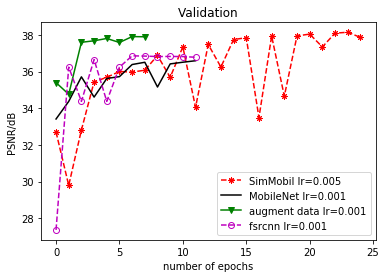

In [150]:
# curve_simmobil, =plt.plot(SimMobil,label='SimMobil lr=0.005')
# curve_mobile,=plt.plot(Mobile_256,label='MobileNet lr=0.001')
# curve_augment,=plt.plot(augment,label='augment data lr=0.001')
# curve_fsrcnn,=plt.plot(fsrcnn,label='fsrcnn lr=0.001')

#plt.plot(SimMobil,label='SimMobil')
#plt.plot(Mobile_256,label='MobileNet')
#plt.plot(augment,label='augment data')
#plt.plot(fsrcnn,label='fsrcnn')
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(SimMobil,c='r',marker=(8,2,0),ls='--',label='SimMobil lr=0.005')
ax.plot(Mobile_256,c='k',ls='-',label='MobileNet lr=0.001')
ax.plot(augment,c='g',marker="v",ls='-',label='augment data lr=0.001')
ax.plot(fsrcnn,c='m',marker="o",ls='--',label='fsrcnn lr=0.001',fillstyle='none')
 
plt.legend(loc=4)



plt.title('Validation')
plt.xlabel('number of epochs')
plt.ylabel('PSNR/dB')
# plt.legend(handles=[curve_simmobil,curve_mobile,curve_augment,curve_fsrcnn])
plt.show()
fig.savefig('./slides/plot.png')